In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, precision_score

import shap

## PREDICCIÓN DE LA CANCELACIÓN DE UNA RESERVA DE UN HOTEL

El objetivo principal del proyecto es encontrar un modelo capaz de predecir si las reservas de un hotel van a ser o no canceladas. Para ello, vamos a tomar un conocidísimo dataset de Kaggle (hotel_booking.cvs). Seguiremos el siguiente esquema:

- En primer lugar, leeremos los datos, los limpiaremos, creando y eliminando las variables que consideremos.

- En segundo lugar, realizaremos un EDA, con el objetivo de comprender el comportamiento de nuestro dataset.

- Finalmente, probaremos distintos modelos (RLogística, Árboles de decisión, RandomForest y XGboost) con el objetivo de encontrar el que mejores predicciones realice. Además, repasaremos los fundamentos teóricos de las distintas métricas y moodelos a estudiar.

### Leemos y limpiamos los datos

In [130]:
data = pd.read_csv("hotel_booking.csv")

##### Descripción de las columnas del dataset

| Column Name                     | Data Type | Description                                                                                      |
|---------------------------------|-----------|--------------------------------------------------------------------------------------------------|
| hotel                           | object    | Nombre del hotel donde se hizo la reserva (por ejemplo, "City Hotel" o "Resort Hotel").          |
| is_canceled                     | int64     | Indicador de cancelación: 1 si la reserva fue cancelada, 0 si no lo fue.                         |
| lead_time                       | int64     | Número de días entre la fecha de reserva y la fecha de llegada.                                  |
| arrival_date_year               | int64     | Año de llegada de la reserva.                                                                    |
| arrival_date_month              | object    | Mes de llegada de la reserva (como texto, por ejemplo, "January", "February").                   |
| arrival_date_week_number        | int64     | Número de la semana del año en la que ocurre la llegada.                                         |
| arrival_date_day_of_month       | int64     | Día del mes en que ocurre la llegada.                                                            |
| stays_in_weekend_nights         | int64     | Número de noches de estadía durante el fin de semana (viernes y sábado).                         |
| stays_in_week_nights            | int64     | Número de noches de estadía durante la semana (lunes a jueves).                                  |
| adults                          | int64     | Número de adultos incluidos en la reserva.                                                      |
| children                        | float64   | Número de niños incluidos en la reserva.                                                        |
| babies                          | int64     | Número de bebés incluidos en la reserva.                                                        |
| meal                            | object    | Tipo de comida reservada: opciones como BB (Bed & Breakfast), HB (Half Board), FB (Full Board).  |
| country                         | object    | Código del país de origen del cliente (por ejemplo, "PRT" para Portugal).                        |
| market_segment                  | object    | Segmento de mercado: cómo se hizo la reserva (por ejemplo, "Direct", "Online TA").               |
| distribution_channel            | object    | Canal de distribución: cómo se distribuyó la reserva (por ejemplo, "Corporate", "Travel Agent"). |
| is_repeated_guest               | int64     | Indicador de si el cliente es un huésped repetido (1 para sí, 0 para no).                        |
| previous_cancellations          | int64     | Número de reservas previas canceladas por el cliente.                                            |
| previous_bookings_not_canceled  | int64     | Número de reservas previas no canceladas por el cliente.                                         |
| reserved_room_type              | object    | Tipo de habitación reservada (por ejemplo, A, B, C).                                             |
| assigned_room_type              | object    | Tipo de habitación asignada finalmente (puede diferir de la reservada).                          |
| booking_changes                 | int64     | Número de cambios realizados en la reserva por el cliente.                                       |
| deposit_type                    | object    | Tipo de depósito realizado: "No Deposit", "Refundable", "Non Refundable".                        |
| agent                           | float64   | Código del agente que gestionó la reserva (si aplica).                                           |
| company                         | float64   | Código de la compañía asociada a la reserva (si aplica).                                         |
| days_in_waiting_list            | int64     | Número de días que la reserva estuvo en lista de espera.                                         |
| customer_type                   | object    | Tipo de cliente: "Transient", "Contract", "Group", etc.                                          |
| adr                             | float64   | Tasa diaria promedio (Average Daily Rate), es decir, ingreso promedio por habitación ocupada.    |
| required_car_parking_spaces     | int64     | Número de espacios de estacionamiento requeridos por el cliente.                                 |
| total_of_special_requests       | int64     | Número de solicitudes especiales hechas por el cliente (por ejemplo, cama extra).                |
| reservation_status              | object    | Estado de la reserva: "Canceled", "Check-Out", "No-Show".                                        |
| reservation_status_date         | object    | Fecha en que se actualizó el estado de la reserva.                                               |
| name                            | object    | Nombre del cliente (puede estar anonimizado).                                                    |
| email                           | object    | Correo electrónico del cliente (puede estar anonimizado).                                        |
| phone-number                    | object    | Número de teléfono del cliente (puede estar anonimizado).                                        |
| credit_card                     | object    | Número de tarjeta de crédito del cliente (puede estar anonimizado).                              |


In [131]:
data.info()

# Analizar el número de valores nulos por columna
null_counts = data.isnull().sum()

# Crear un DataFrame con el número y porcentaje de nulos
null_analysis = pd.DataFrame({
    "Column Name": null_counts.index,
    "Number of Nulls": null_counts.values,
    "Percentage of Nulls (%)": (null_counts.values / len(data)) * 100
})

# Ordenar el resultado por número de nulos de forma descendente
null_analysis = null_analysis.sort_values(by="Number of Nulls", ascending=False)

# Mostrar el resultado
print(null_analysis)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

Tenemos 36 columnas y 119390 filas. Vamos ahora a tratar de manera independiente las variables categóricas de las variables numéricas. Vamos a analizar los valores nulos que aparecen en las distintas columnas y un resumen de ellas.

##### Variables Categóricas

In [132]:
# Fijándonos en la descripción de las columnas del dataset tenemos:
categorical_columns = [
    'hotel',
    'is_canceled',
    'arrival_date_year',
    'arrival_date_month',
    'arrival_date_week_number',
    'arrival_date_day_of_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
    'name',
    'email',
    'phone-number',
    'credit_card'
]

# Vamos a convertir estas columnas a tipo str, ya que deberán ser tratados como categorías aunque almacenen valores numéricos
for column in categorical_columns:
    if column in data.columns:
        data[column] = data[column].astype(str)

In [133]:
# Ahora, vamos a obtener un sumario de las estadísticas de estas variables
data.describe(include='object').T

,count,unique,top,freq
hotel,119390,2,City Hotel,79330
is_canceled,119390,2,0,75166
arrival_date_year,119390,3,2016,56707
arrival_date_month,119390,12,August,13877
arrival_date_week_number,119390,53,33,3580
arrival_date_day_of_month,119390,31,17,4406
meal,119390,5,BB,92310
country,119390,178,PRT,48590
market_segment,119390,8,Online TA,56477
distribution_channel,119390,5,TA/TO,97870


Antes hemos visto que company, agent y country tienen valores nulos. Ahora, con las variables categóricas que escojamos más adelante, lo que haremos será "pivotar" estas columnas. Es decir, crear tantas columnas nuevas como valores diferentes tengamos en cada categoría y rellenarlas con 1 o 0 según pertenezcan o no las filas.
Por ello, realmente no es necesario rellenar estos nulos con nada, ya que simplemente estas filas tendrán un 0 en todas las columnas nuevas que se creen de la categoría y ya.

##### Variables numéricas

In [134]:
# Obtenemos un resumen de las variables numéricas
data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
previous_bookings_not_canceled,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0
booking_changes,119390.0,0.221124,0.652306,0.00,0.00,0.000,0.0,21.0
days_in_waiting_list,119390.0,2.321149,17.594721,0.00,0.00,0.000,0.0,391.0


Podemos ver cómo hay algunas variables que podrían presentar ciertos errores. Por ejemplo, el máximo de la reserva de adultos es 55 o el menor ADR -6.38. Es posible que esto se deban a reservas concretas de un grupo muy grande y donde otra donde pierden dinero, pero también es posible que sean errores que podrían desbalancear nuestro modelo. De momento no vamos a eliminar ningún dato del dataset, pero guardamos esta idea porque después puede ser interesante.

Por otro lado, anteriormente hemos visto que la columna "children" tiene 4 valores nulos. Vamos a suponer que, estos valores faltan porque realmente no había ningún niño en la reserva, por lo que vamos a cambiar estos nulos por 0.

In [135]:
# Reemplazar los valores nulos en la columna 'children' por 0
data['children'].fillna(0, inplace = True)

C:\Users\4sell\AppData\Local\Temp\ipykernel_14480\2671540527.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['children'].fillna(0, inplace = True)


#### FEATURE ENGINEERING

1º - Creamos columnas que pueden ser interesantes.

- En primer lugar, vamos a tomar el número de reservas que ha realizado una persona. Para ello, vamos a tomar el número de veces que se repiten los correos

In [136]:
# Calcular el número de reservas por correo electrónico
email_counts = data['email'].value_counts()
# Crear un DataFrame con los conteos
email_counts_df = email_counts.reset_index()
email_counts_df.columns = ['email', 'n_reservations']
# Unir los conteos al DataFrame original
data = data.merge(email_counts_df, on='email', how='left')

- En segundo lugar, vamos a crear una columna binaria para analizar si las habitaciones asignadas coinciden con las reservadas. Si no coinciden, pondremos un 1, y si coinciden un 0. La idea es que es posible que a la hora de la asignación pudo haber un error en la reserva, y este puede ser un motivo posible de cancelación

In [137]:
# Crear la nueva columna 'different_room_reserved_assigned'
data['different_room_reserved_assigned'] = (data['reserved_room_type'] != data['assigned_room_type']).astype(int)

2º - Pivotar variables categóricas


En primer lugar, como hemos comentado antes, "pivotamos" las variables categóricas. Para ello, tenemos varias opciones. En primer lugar, las variables que ya son binarias, las dejaMos así. Y, las que tienen varias categorías, analizamos si el orden de ellas es influyente, y realizamos un "Label Encoding", donde simplemente ordenamos los valores; por ejemplo, los meses del año deben estar ordenados. Finalmente, las otras columnas que tienen varias categorías, las trataremos con One-Hot Encoding.

In [138]:
# Tomamos las columnas a las que le aplicamos el One-Hot Encoding
one_hot = ['hotel', 'meal', 'market_segment','distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type', 'country', 'arrival_date_month'] #añadiendo country el número de columnas aumenta considerablemente, de momento vamos a tomarlo y después veremos si lo eliminamos del modelo o no
data = pd.get_dummies(data, columns=one_hot, drop_first=True)


data.columns


Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies',
       ...
       'arrival_date_month_December', 'arrival_date_month_February',
       'arrival_date_month_January', 'arrival_date_month_July',
       'arrival_date_month_June', 'arrival_date_month_March',
       'arrival_date_month_May', 'arrival_date_month_November',
       'arrival_date_month_October', 'arrival_date_month_September'],
      dtype='object', length=247)

3º - Eliminar columnas

Ahora, vamos a eliminar columnas que no consideramos necesarias para nuestro análisis.
- 'arrival_date_year': La idea es analizar a futuro si una reserva será cancelada, por lo que no parece interesante esta columna para entrenar el modelo.
- 'reservation_status_date': Tras analizar esta columna, resulta que si la reserva había sido cancelada, entonces esta fecha era previa a la fecha de la reserva; mientras que si la reserva no era cancelada, la fecha era posterior. Por ello, tras pensar en obtener alguna columna y cálculo a partir de ella, concluimos que no tiene sentido trabajar con ella, ya que alteraría el modelo.
- 'email', 'name', 'phone-number', 'company', 'credit_card': No nos interesan los datos personales de comprador. Podríamos hacer distinción por países y compañías, pero de momento vamos a trabajar sin estas variables, y nos guardamos la idea de usarlas para un futuro.
- 'assigned_room_type': Es la habitación que finalmente se asigna. Como estamos analizando las cancelaciones de las reservas, hemos decidido pivotar únicamente la columna de 'reserved_room_type'.
- 'reservation_status' : Muestra el estado de la reserva. No tiene sentido esta variable ya que estamos analizando si se ha cancelado o no, y esta variable nos indica esto ya.
- 'company', 'agent': De momento vamos a eliminar estas, ya que si las pivotábamos teníamos muchas columnas. Nos lo guardamos para en un futuro añadirlo con la posibilidad de mejorar el modelo.

In [139]:
# Eliminar las columnas no necesarias
columns_to_drop = [
    'arrival_date_year',
    'reservation_status_date',    
    'email',                 
    'name',                  
    'phone-number',                 
    'company',  
    'agent',         # Las vamos a dejar fuera de momento
    'credit_card',           
    'assigned_room_type',    
    'reservation_status',  
]

# Eliminar las columnas
data = data.drop(columns=columns_to_drop)


### Realizamos un pequeño EDA

En primer lugar, analizamos la proporción de reservas canceladas/no canceladas que tenemos

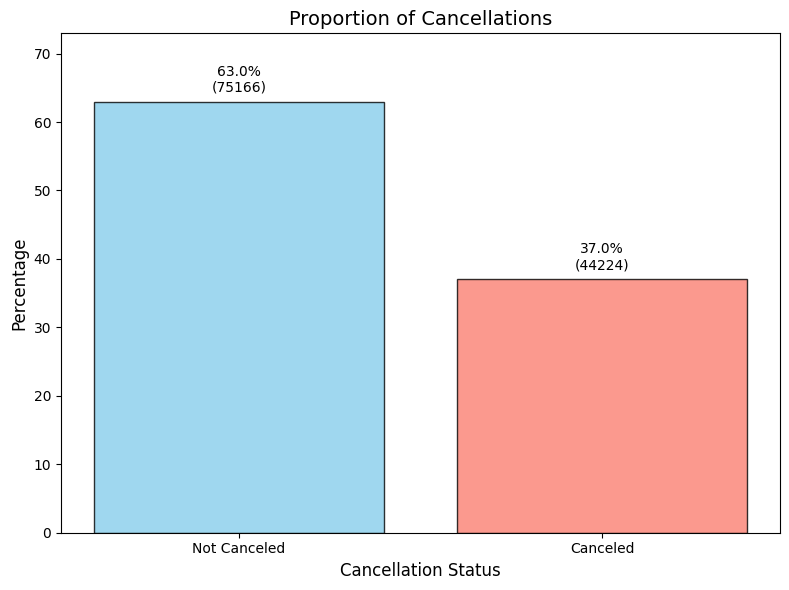

In [140]:
# Calcular la proporción y el conteo total de cada categoría
cancel_counts = data['is_canceled'].value_counts()
cancel_percentages = (cancel_counts / len(data)) * 100
# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(cancel_counts.index, cancel_percentages, color=['skyblue', 'salmon'], alpha=0.8, edgecolor='black')
# Añadir etiquetas a las barras
for bar, count, percentage in zip(bars, cancel_counts, cancel_percentages):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # Posición x (centro de la barra)
        bar.get_height() + 1,  # Posición y (ligeramente encima de la barra)
        f'{percentage:.1f}%\n({count})',  # Texto de la etiqueta
        ha='center', va='bottom', fontsize=10, color='black'
    )
# Configurar el gráfico
ax.set_title('Proportion of Cancellations', fontsize=14)
ax.set_xlabel('Cancellation Status', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Not Canceled', 'Canceled'], fontsize=10)
ax.set_ylim(0, max(cancel_percentages) + 10)  # Añadir espacio para las etiquetas
# Mostrar el gráfico
plt.tight_layout()
plt.show()



Contamos con un pequeño desbalance entre las reservas. Tenemos más no canceladas que canceladas. Sin embargo, no es nada preocupante, ya que contamos con casi un 40% del dataset de reservas canceladas.

Veamos ahora cómo tenemos los datos distribuidos por fechas. Vamos a ver el número de datos que tenemos por semana del año, ya que solo tenemos datos de 1 año.

C:\Users\4sell\AppData\Local\Temp\ipykernel_14480\3721637869.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='arrival_date_week_number', data=data, palette='viridis', order=sorted(data['arrival_date_week_number'].dropna().unique()))


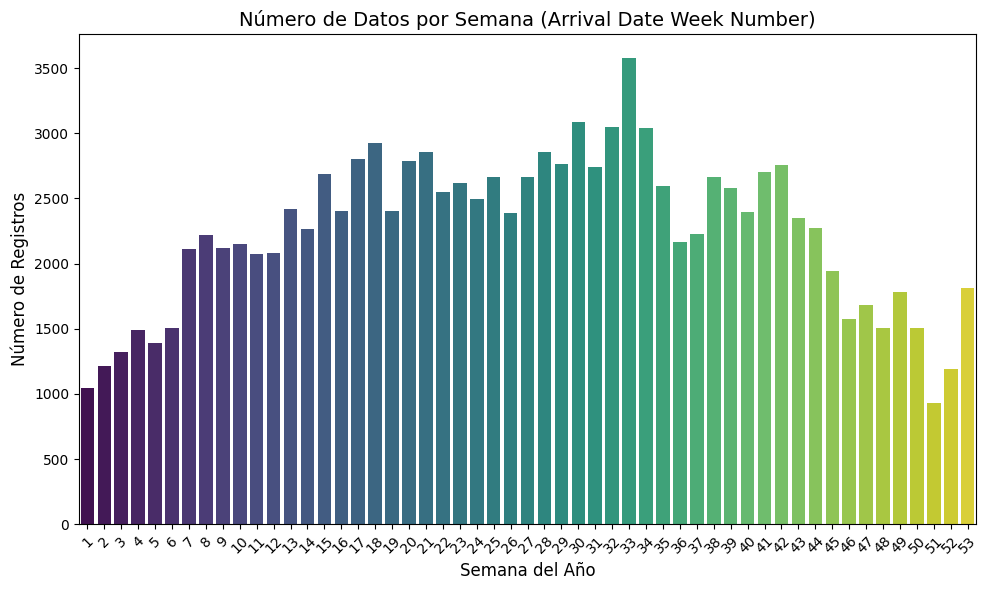

In [141]:
# Convertir la columna 'arrival_date_week_number' a valores numéricos (en caso de que sea de tipo texto)
data['arrival_date_week_number'] = pd.to_numeric(data['arrival_date_week_number'], errors='coerce')

# Crear el gráfico de barras ordenado por 'arrival_date_week_number'
plt.figure(figsize=(10, 6))
sns.countplot(x='arrival_date_week_number', data=data, palette='viridis', order=sorted(data['arrival_date_week_number'].dropna().unique()))

# Etiquetas y título
plt.title('Número de Datos por Semana (Arrival Date Week Number)', fontsize=14)
plt.xlabel('Semana del Año', fontsize=12)
plt.ylabel('Número de Registros', fontsize=12)

# Mostrar el gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas en el eje X si es necesario
plt.tight_layout()  # Ajustar el layout para que no se corten las etiquetas
plt.show()

Ahora, obtenemos un pequeño resumen de las variables numéricas con el fin de seleccionar las más interesantes a analizar

In [142]:
# Obtenemos un resumen de las variables numéricas
data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119390.0,0.103886,0.398555,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
previous_bookings_not_canceled,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0
booking_changes,119390.0,0.221124,0.652306,0.00,0.00,0.000,0.0,21.0


Obtenemos histogramas de algunos para analizar su distribución y su comportamiento

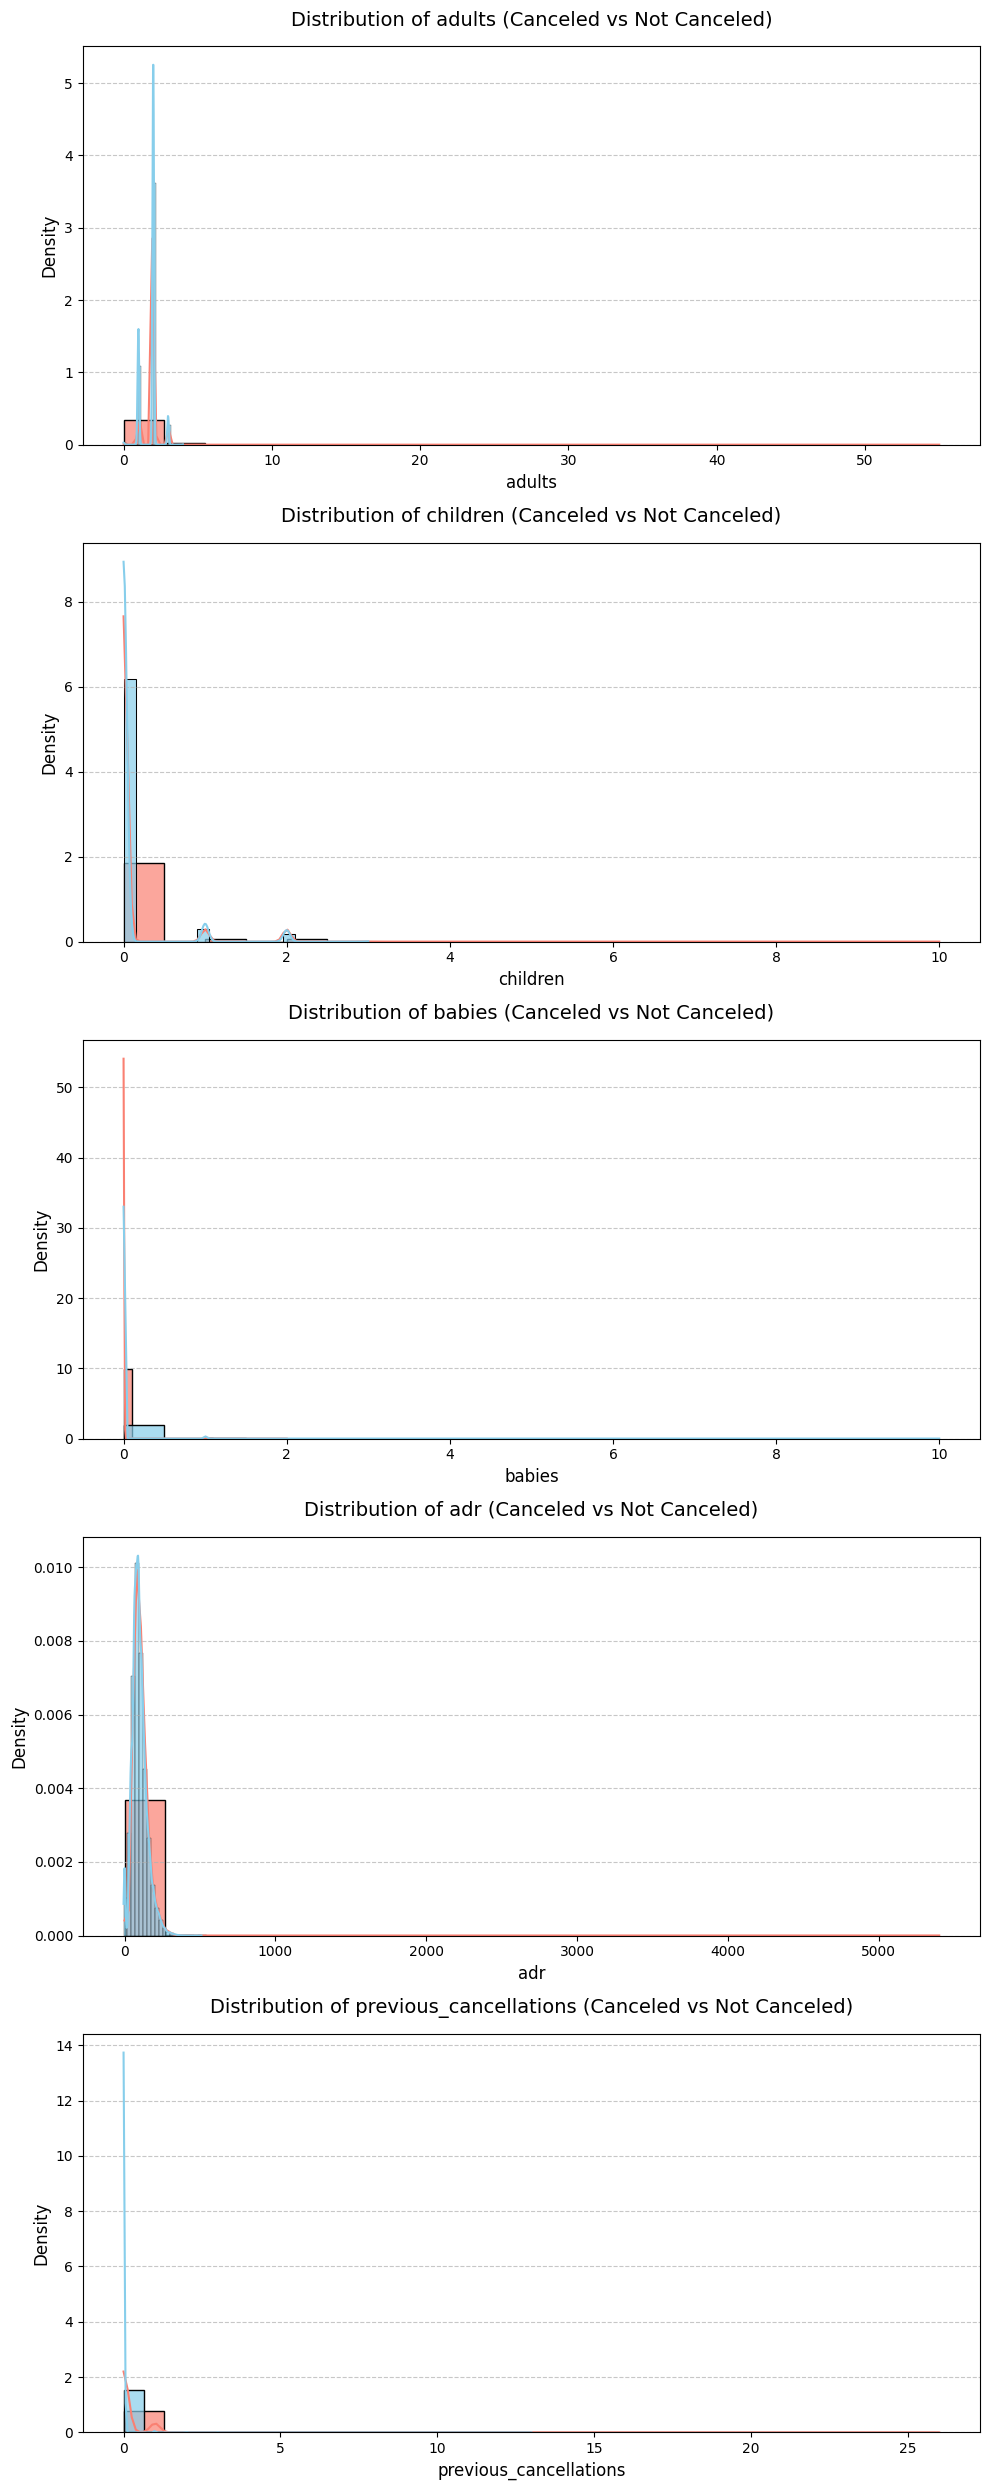

In [143]:
data['is_canceled'] = data['is_canceled'].astype(int)
# Dividir los datos en cancelados y no cancelados
canceled = data[data['is_canceled'] == 1]
not_canceled = data[data['is_canceled'] == 0]

# Variables para el análisis
variables = ['adults', 'children', 'babies', 'adr', 'previous_cancellations']

# Configuración de subplots
fig, axes = plt.subplots(len(variables), 1, figsize=(10, 25))  # Un subplot por fila
axes = axes.ravel()

for i, var in enumerate(variables):
    # Crear histogramas normalizados (density)
    sns.histplot(canceled[var], bins=20, stat="density", kde=True, color='salmon', label='Canceled', ax=axes[i], alpha=0.7)
    sns.histplot(not_canceled[var], bins=20, stat="density", kde=True, color='skyblue', label='Not Canceled', ax=axes[i], alpha=0.7)
    
    # Configuración del gráfico
    axes[i].set_title(f'Distribution of {var} (Canceled vs Not Canceled)', fontsize=14, pad=15)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)  # Cambiamos "Frequency" por "Density"
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar diseño
plt.tight_layout()
plt.show()


Vamos a analizar algunas cosas interesantes.

- Las personas que tienen varias cancelaciones previas, tienen más probabilidad de cancelar. Podemos observar en esta tabla, el ratio de personas que cancelan según el número de reservas previas canceladas que tengan.

In [144]:
# Crear una tabla agrupada por previous_cancellations y is_canceled
grouped_data = data.groupby(['previous_cancellations', 'is_canceled']).size().unstack(fill_value=0)

# Renombrar columnas para mayor claridad
grouped_data.columns = ['not_canceled', 'canceled']

# Calcular el total y el ratio
grouped_data['total'] = grouped_data['not_canceled'] + grouped_data['canceled']
grouped_data['cancellation_ratio'] = grouped_data['canceled'] / grouped_data['total']

# Resetear el índice para una visualización más clara
grouped_data = grouped_data.reset_index()

# Mostrar la tabla
display(grouped_data)

,previous_cancellations,not_canceled,canceled,total,cancellation_ratio
0,0,74624,38282,112906,0.339061
1,1,337,5714,6051,0.944307
2,2,78,38,116,0.327586
3,3,45,20,65,0.307692
4,4,24,7,31,0.225806
5,5,17,2,19,0.105263
6,6,15,7,22,0.318182
7,11,25,10,35,0.285714
8,13,1,11,12,0.916667
9,14,0,14,14,1.000000


Analizamos la correlación entre las variables numéricas

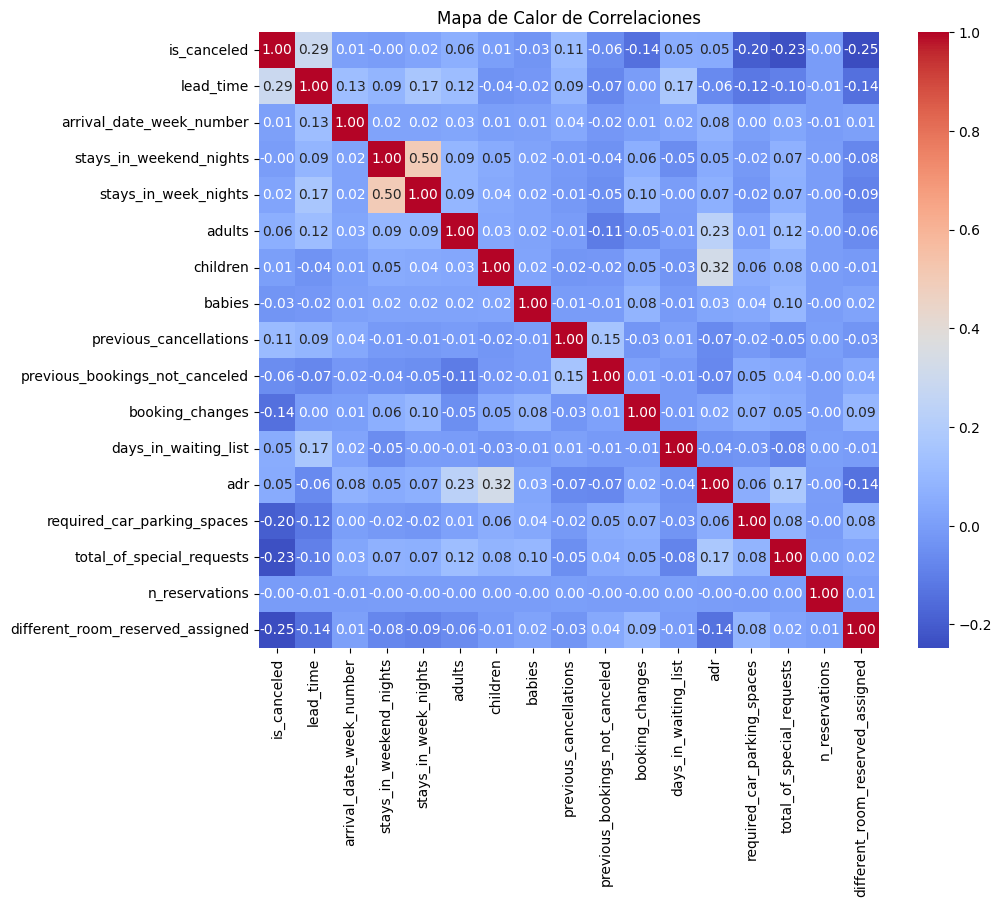

In [145]:
# Seleccionar solo las columnas numéricas
numeric_data = data.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = numeric_data.corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de Calor de Correlaciones")
plt.show()

Podemos observar que existen pocas correlaciones entre ellas, por ello no eliminaremos ninguna.

### Comenzamos a modelar

Resumen de métricas para clasificación Binaria (github:)

Nuestra idea es predecir si una habitación va a ser cancelada o no, con la idea quizás de hacer un control de Overbooking y poner más habitaciones a la venta. Para este estudio, pienso que es muy importante minimizar los errores de tipo I, es decir, minimizar el número de veces que predecimos una habitación cancelada que al final resulta no serlo. Es decir, si predecimos una cancelación, debemos estar bastante seguros de que es cierta. Ya que, si lo utilizamos para controalr el Overbooking, en cada fallo que cometamos, vamos a dejar a personas sin habitación, lo que puede producir una muy mala imagen del hotel y gasto en indemnizaciones. Por ello, vamos a tomar como métrica de referencia en principio la Precisión, que mide el número de aciertos de clase 1 partido el número de clasificaciones totales de clase 1 que hemos hecho.

$$
\text{Precisión} = \frac{TP}{TP + FP}
$$

En primer lugar, vamos a realizar una división simple de nuestro dataset en train-test, tomando un 80% de la muestra como train y 20% como test.

In [146]:
data['is_repeated_guest'] = data['is_repeated_guest'].astype(int).astype(bool) #pasamos esta a boolean porque da problemas

columns_to_drop = ['arrival_date_week_number', 'arrival_date_day_of_month'] 
data = data.drop(columns=columns_to_drop)

X = data.drop('is_canceled', axis=1) 
y = data['is_canceled']  

# Dividimos 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Regresión Logística

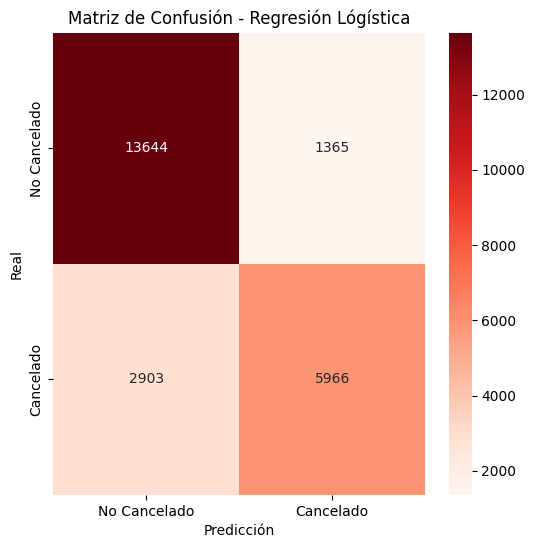

F1 Score: 0.7365
Accuracy: 0.8213
Precision: 0.8138


In [147]:
# 1. Ajustamos el modelo de regresión logística
model = LogisticRegression(random_state=4)
model.fit(X_train_scaled, y_train)

# 2. Realizamos las predicciones sobre el conjunto de test
y_pred = model.predict(X_test_scaled)

# 3. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Regresión Lógística')
plt.show()

# 4. Métricas
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Imprimimos las métricas
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')

Con el fin de prácticar, vamos a intentar mejorar nuestro modelo analizando el threshold que podría ser más interesante.
Partiendo de él, si aumentamos el threshold, entonces nuestra precisión mejorará, ya que seremos más conservadores a la hora de predecir un 1. Esto, puede resultar interesante para nuestro caso, ya que, como hemos dicho, nuestro objetivo principal será predecir una cancelación estando seguros de no fallar.

En primer lugar, vamos a ver cómo clasifica nuestro modelo:

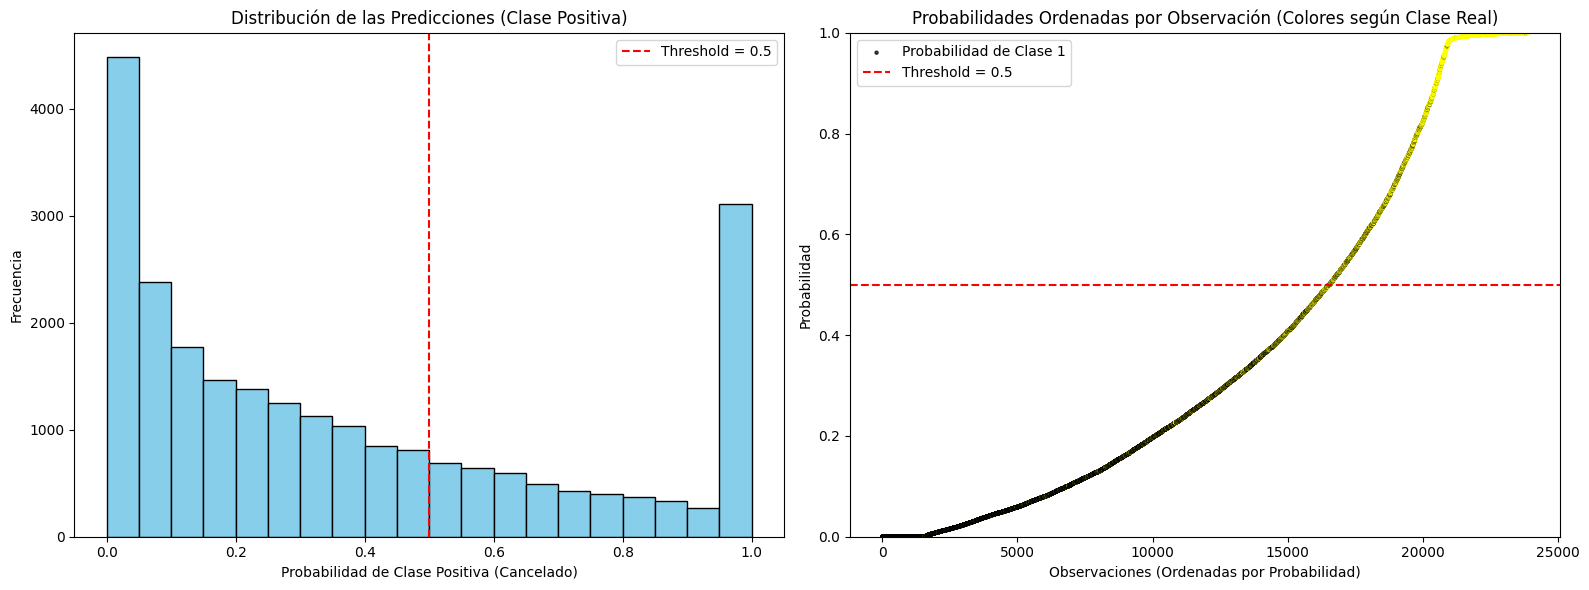

In [148]:
# Obtenemos las probabilidades de la clase positiva (Cancelado)
y_pred_proba_positive = model.predict_proba(X_test_scaled)[:, 1]

# Ordenamos las probabilidades de la clase positiva y asociamos las clases reales
sorted_indices = np.argsort(y_pred_proba_positive)
sorted_positive_probs = y_pred_proba_positive[sorted_indices]
sorted_real_classes = y_test.iloc[sorted_indices]  # Asegúrate de que y_test esté indexado correctamente

# Creamos colores: azul para clase 1, rojo para clase 0
colors = ['yellow' if cls == 1 else 'black' for cls in sorted_real_classes]

# Creamos la figura y los subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Histograma de probabilidades
axes[0].hist(y_pred_proba_positive, bins=20, color='skyblue', edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')  # Línea del umbral
axes[0].set_title('Distribución de las Predicciones (Clase Positiva)')
axes[0].set_xlabel('Probabilidad de Clase Positiva (Cancelado)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

# Subplot 2: Scatter plot de probabilidades ordenadas con colores según clase real
axes[1].scatter(range(len(sorted_positive_probs)), sorted_positive_probs, color=colors, alpha=0.7, s=5, label='Probabilidad de Clase 1')
axes[1].axhline(y=0.5, color='red', linestyle='--', label='Threshold = 0.5')  # Línea del umbral
axes[1].set_title('Probabilidades Ordenadas por Observación (Colores según Clase Real)')
axes[1].set_xlabel('Observaciones (Ordenadas por Probabilidad)')
axes[1].set_ylabel('Probabilidad')
axes[1].set_ylim(0, 1)  # Limitar eje Y entre 0 y 1
axes[1].legend()

# Mostramos los subplots
plt.tight_layout()
plt.show()


En la primera gráfica podemos ver un histograma sobre cómo están distribuidas nuestras probabilidades predichas de pertenecer a clase 1.
Y, en la segunda, podemos ver, en color amarillo las reservas que han sido canceladas, y en color negro las que no lo han sido. Y, en el eje X las tenemos ordenadas por la probabilidad que hemos dado de pertenecer a clase 1, mientras que en el eje y se muestra esta probabilidad. 

Podemos observar a simple vista que el modelo es bastante bueno y predice muy bien las reservas que van a ser canceladas. Jugando un poco "a ojo", podemos ver que entre las probabilidades 0.4 - 0.8 es donde más está fallando (clasifica muchos que deberían ser amarillos como negros y viceversa), y más le cuesta diferenciar.

Por ello, una sencilla solución para aplicar este modelo de una forma óptima, podría ser simplemente tomar un threshold = 0.8. De esta manera, aumentamos considerablemente nuestra precisión (hasta el 0.9656), y nos aseguramos más en acertar al predecir una cancelación.

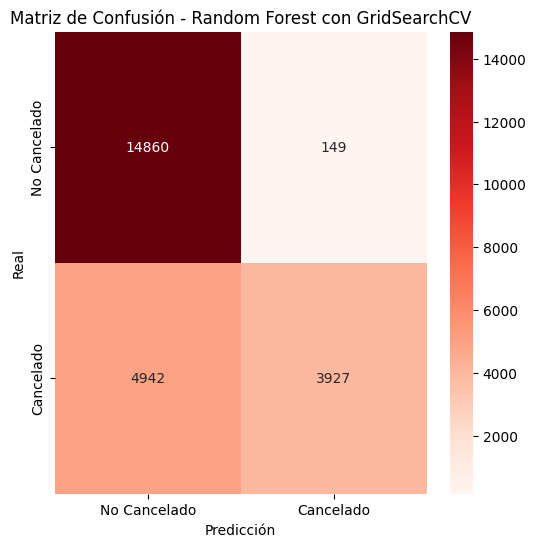

F1 Score (umbral 0.8): 0.6067
Accuracy (umbral 0.8): 0.7868
Precision (umbral 0.8): 0.9634


In [149]:
# Definimos un nuevo umbral
threshold = 0.8 # Cambia el valor según lo desees

# Clasificamos según el nuevo umbral
y_pred_custom = (y_pred_proba_positive >= threshold).astype(int)

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_custom)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest con GridSearchCV')
plt.show()

# Evaluamos las métricas con el nuevo umbral
f1_custom = f1_score(y_test, y_pred_custom)
accuracy_custom = accuracy_score(y_test, y_pred_custom)
precision_custom = precision_score(y_test, y_pred_custom)

# Imprimimos las nuevas métricas
print(f'F1 Score (umbral {threshold}): {f1_custom:.4f}')
print(f'Accuracy (umbral {threshold}): {accuracy_custom:.4f}')
print(f'Precision (umbral {threshold}): {precision_custom:.4f}')

### RandomForest

En árboles de decisión, tener las variables escaladas no suma ni resta. En este caso, vamos a utilizar el dataframe sin escalar.

Comenzamos con un RandomForest simple

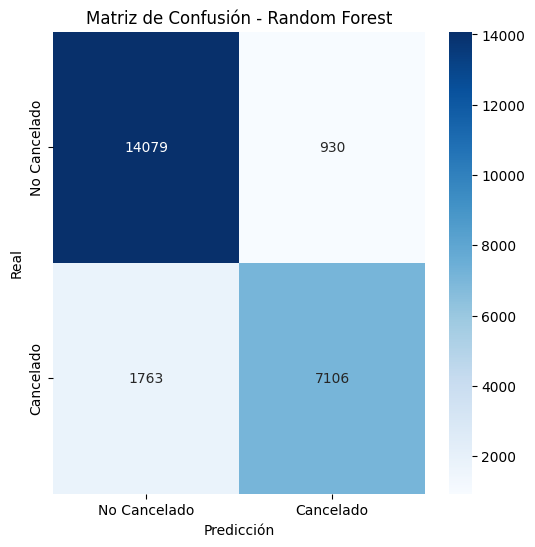

F1 Score (Random Forest): 0.8407
Accuracy (Random Forest): 0.8872
Precision (Random Forest): 0.8843


In [150]:
# 1. Ajustamos el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=4)
rf_model.fit(X_train, y_train)

# 2. Realizamos las predicciones sobre el conjunto de test
y_pred_rf = rf_model.predict(X_test)

# 3. Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

# 4. Métricas
f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)

# Imprimimos las métricas
print(f'F1 Score (Random Forest): {f1_rf:.4f}')
print(f'Accuracy (Random Forest): {accuracy_rf:.4f}')
print(f'Precision (Random Forest): {precision_rf:.4f}')

Vamos ahora a intentar mejorarlo con GridShearch, utilizando la precisión como métrica para comparar modelos.

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


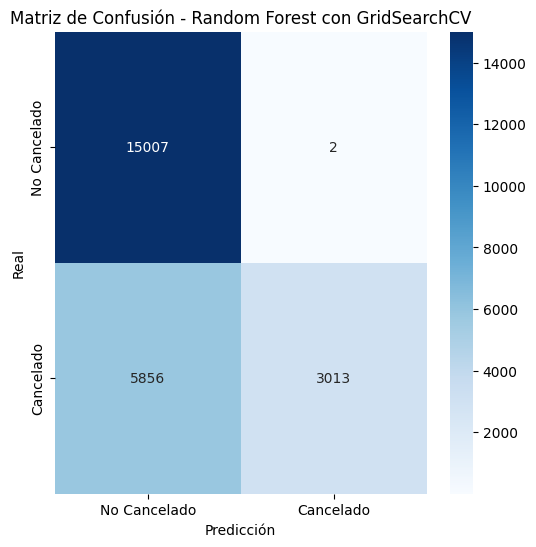

F1 Score (Random Forest): 0.5071
Accuracy (Random Forest): 0.7547
Precision (Random Forest): 0.9993


In [151]:
# 1. Definir el modelo Random Forest
rf_model = RandomForestClassifier(random_state=4)

# 2. Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],  # Número de árboles en el bosque
    'max_depth': [5, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5],  # Número mínimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 2],    # Número mínimo de muestras en una hoja
    'max_features': ['sqrt', 'log2']  # Número de características a considerar para cada división
}

# 3. Realizar GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='precision')
grid_search.fit(X_train, y_train)

# 4. Mostrar los mejores parámetros encontrados
print(f'Best Parameters: {grid_search.best_params_}')

# 5. Obtener el modelo con los mejores parámetros
best_rf_model = grid_search.best_estimator_

# 6. Realizar las predicciones sobre el conjunto de test
y_pred_rf = best_rf_model.predict(X_test)

# 7. Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest con GridSearchCV')
plt.show()

# 8. Métricas
f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)

# Imprimimos las métricas
print(f'F1 Score (Random Forest): {f1_rf:.4f}')
print(f'Accuracy (Random Forest): {accuracy_rf:.4f}')
print(f'Precision (Random Forest): {precision_rf:.4f}')

Podríamos seguir viendo más métricas igual que antes y maneras de mejorar nuestro modelo. Sin embargo, creo que el resultado ya es bastante bueno como para quedarnos aquí. Los datos parecen sospechosamente buenos como para ser ciertos.

### XGBoost

Con el objetivo de seguir practicando, vamos a probar ahora si con un XGboost podríamos incluso mejorar nuestro último RF.

Comenzamos con un Xgboost simple, sin tocar nada

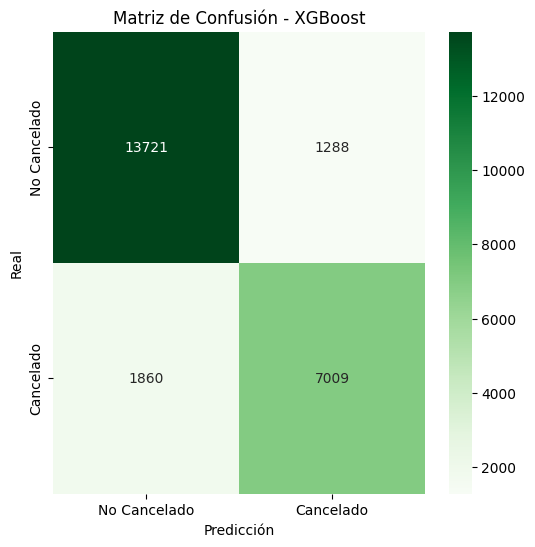

F1 Score (XGBoost): 0.8166
Accuracy (XGBoost): 0.8682
Precision (XGBoost): 0.8448


In [152]:
# 1. Ajustamos el modelo de XGBoost
xgb_model = XGBClassifier(random_state=4, use_label_encoder=False, eval_metric='logloss')  # use_label_encoder=False para evitar warnings
xgb_model.fit(X_train, y_train)

# 2. Realizamos las predicciones sobre el conjunto de test
y_pred_xgb = xgb_model.predict(X_test)

# 3. Matriz de confusión
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# 4. Métricas
f1_xgb = f1_score(y_test, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)

# Imprimimos las métricas
print(f'F1 Score (XGBoost): {f1_xgb:.4f}')
print(f'Accuracy (XGBoost): {accuracy_xgb:.4f}')
print(f'Precision (XGBoost): {precision_xgb:.4f}')

Obtenemos unos resultados muy buenos. Vamos ahora a mejorar el modelo utilizando gridsearch, igual que antes.

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}


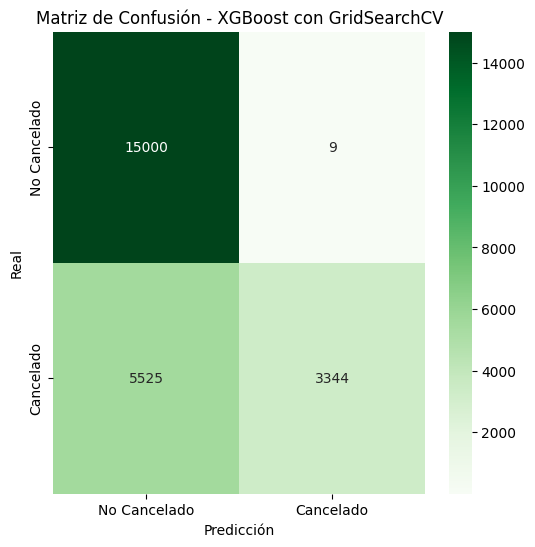

F1 Score (Best XGBoost): 0.5472
Accuracy (Best XGBoost): 0.7682
Precision (Best XGBoost): 0.9973


In [153]:
# Definimos el modelo base
xgb_model = XGBClassifier(random_state=4, use_label_encoder=False, eval_metric='logloss')

# Definimos la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],          # Número de árboles
    'max_depth': [3, 5, 7],                  # Profundidad máxima de los árboles
    'learning_rate': [0.01, 0.1, 0.2],       # Tasa de aprendizaje
    'subsample': [0.8, 1.0],                 # Fracción de muestras utilizadas para entrenar cada árbol
    'colsample_bytree': [0.8, 1.0],          # Fracción de características utilizadas por árbol
    'gamma': [0, 1, 5],                      # Reducción mínima de la pérdida para hacer una división
}

# Configuramos el GridSearchCV con precision como métrica
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=make_scorer(precision_score, average='binary'),  # Optimiza la precisión de la clase positiva
    cv=3,                      # Número de divisiones para validación cruzada
    verbose=1,                 # Nivel de detalle
    n_jobs=-1                  # Usa todos los núcleos disponibles
)

# Ejecutamos el GridSearchCV
grid_search.fit(X_train, y_train)

# Mostramos los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluamos el mejor modelo
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_best)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost con GridSearchCV')
plt.show()

# Calculamos métricas
f1_best = f1_score(y_test, y_pred_best)
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)

print(f'F1 Score (Best XGBoost): {f1_best:.4f}')
print(f'Accuracy (Best XGBoost): {accuracy_best:.4f}')
print(f'Precision (Best XGBoost): {precision_best:.4f}')

### Conclusión

Los resultados de todos los modelos son bastante buenos en general para predecir con exactitud una reserva cancelada. Es decir, si el modelo dice que una habitación va a ser cancelada, es muy probable que acierte y no se equivoque. 

Por otro lado, sí es cierto que comparado con los otros modelos, los mejores RF y XGBoost han sido mucho más conservadores a la hora de predecir cancelaciones, éste es probablemente el motivo por el que ha acertado tanto en este aspecto. Sin embargo, han fallado también mucho en la predicción de algunas habitaciones canceladas, clasificándolas como no canceladas.

Por ello, pienso que a la hora de modelar y escoger el modelo debemos adaptarnos a las necesidades del negocio. Por un lado, si trabajamos como hemos dicho al incio, siendo una cadena hotelera con miles de reservas cada día, este modelo puede resultar muy interesante, ya que podremos estar bastantes seguros a la hora de afirmar que una reserva va a ser cancelada. En este caso, serían útiles para controlar el overbooking de una manera muy fiable y segura. Sin embargo, por otro lado, si somos una pequeña empresa con pocas habitaciones, quizá el modelo prediga muy pocas como canceladas, y no nos sirva. En este caso es posible que debiéramos tomar otra métrica y utilizar algo más "arriesgado", esperando resultados más similares a el primer árbol de decisión. En un caso así, seguimos estando en unos niveles de error considerablemente bajos.

Finalmente, a la hora de escoger entre el RF y XGB, me quedaría con el RF ya que es algo más conservador pero tiene un único error de tipo I, lo cual es increíble.